<h1>Table of Contents &lt;br&gt;&lt;/br&gt;<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-and-Data-loading" data-toc-modified-id="Imports-and-Data-loading-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports and Data loading</a></span></li><li><span><a href="#Result-loader" data-toc-modified-id="Result-loader-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Result loader</a></span></li><li><span><a href="#Seaborn-Style" data-toc-modified-id="Seaborn-Style-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Seaborn Style</a></span></li><li><span><a href="#Plotting-Function" data-toc-modified-id="Plotting-Function-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Plotting Function</a></span></li></ul></li><li><span><a href="#Profit-comparison" data-toc-modified-id="Profit-comparison-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Profit comparison</a></span></li></ul></div>

## Imports and Data loading

In [1]:
# Display plots inline
%matplotlib inline

# Autoreload all package before excecuting a call
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from evsim.data import load

## Result loader

In [34]:
pd.set_option('display.float_format', '{:.4f}'.format)

start = "2016-06-01"
end = "2018-01-01"

def read_results(path):
    df = pd.read_csv(path)
    
    df["profit_eur"] = df["profit_eur"] - df["lost_rentals_eur"]
    df["charged_vpp_kwh"] = df["charged_vpp_kwh"] / 1000
    
    df["timestamp"] = df["timestamp"].apply(lambda x : datetime.fromtimestamp(x))
    df = df.set_index("timestamp") 
    df = df[start:end]
    return df

## Seaborn Style

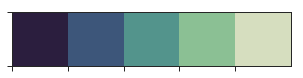

In [4]:
sns.set(rc={'figure.figsize':(10,6)})

sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 1.5, "lines.markersize": 7})

sns.set_style("white")
sns.set_style("ticks")


palette = sns.cubehelix_palette(5, start=.5, rot=-.75, reverse=True)
sns.set_palette(palette)

sns.palplot(palette)

## Plotting Function

In [35]:
def result_comp(dfs, names, a, y_col="profit_eur", y_name="Gross profit increase [EUR]"):
    df_results = pd.DataFrame(columns=["timestamp", "Strategy", y_name])
    for df, name in zip(dfs, names):
        
        df = df.groupby(pd.Grouper(freq="M")).sum()
        df[y_name] = df[y_col].cumsum()
        df = df.reset_index()
        df["Strategy"] = name
        df = df[["timestamp", "Strategy", y_name]]

        df_results = df_results.append(df)

    
    ax = sns.lineplot(x="timestamp", y=y_name,
                      hue="Strategy", style="Strategy",
                      markers=True, dashes=False, ci="sd", data=df_results, ax=a)

    ax.set(xlabel="")

# Profit comparison

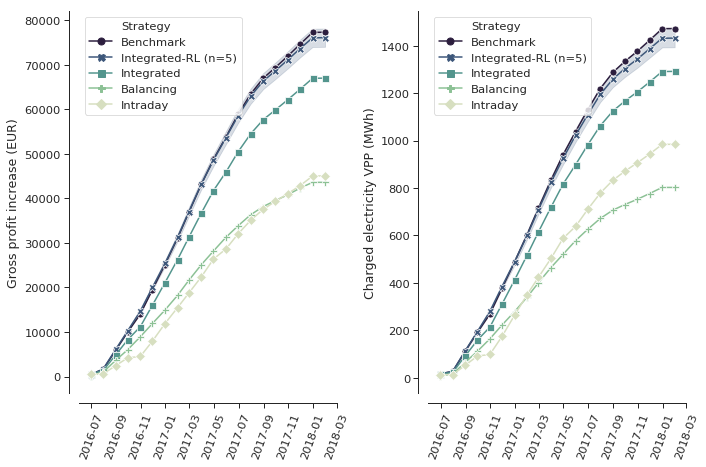

In [43]:
df_bench = read_results("../results/integrated-benchmark-acc-1.csv")
df_int = read_results("../results/integrated-risk-averse.csv")

df_rl1 = read_results("../results/integrated-rl-1.csv")
df_rl2 = df_rl1 * 0.99
df_rl3 = df_rl1 * 0.95

df_bal = df = read_results("../results/balancing-risk-averse.csv")
df_intr = df = read_results("../results/intraday-risk-averse.csv")

f, axs = plt.subplots(1, 2)
y_cols=["profit_eur", "charged_vpp_kwh"]
y_names=["Gross profit increase (EUR)", "Charged electricity VPP (MWh)"]

for ax, y_col, y_name in zip(axs, y_cols, y_names):
    result_comp(
        [
            df_bench,
            df_rl1,
            df_rl2,
            df_rl3,
            df_int,
            df_bal,
            df_intr,
        ],
        [
            "Benchmark",
            "Integrated-RL (n=5)",
            "Integrated-RL (n=5)",
            "Integrated-RL (n=5)",
            "Integrated",
            "Balancing",
            "Intraday",
        ],
        ax, y_col, y_name
    )
    
f.tight_layout()
sns.despine(offset=10)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=70)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=70)
plt.savefig("../results/fig/rl-results.png")